In [17]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from functools import lru_cache
import os
from scipy.spatial.distance import pdist, squareform

In [18]:
input_dim = 400
num_points = 50
hidden_dim = 128
batch_size = 128
epochs = 100
lr = 0.001

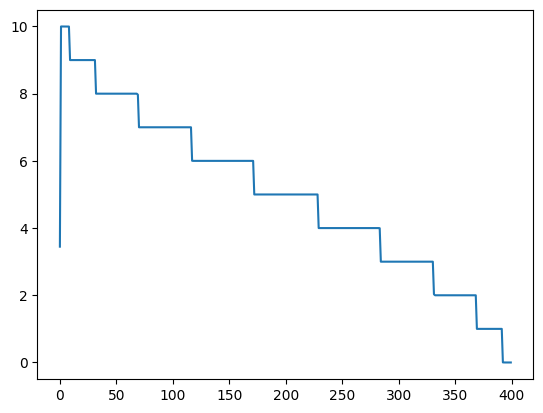

In [19]:
pris = np.loadtxt(os.path.expanduser('~/Downloads/transmissions/size_10/size_10_pris.csv'), delimiter=',')
plt.plot(pris)

In [20]:
size = 10
@lru_cache(maxsize=1024)
def configs(conc):
    df = {}
    for x in range(5000):
        path = os.path.expanduser(f'~/Downloads/transmissions/size_10/lead_size_10_conc_{conc}_config_{x}.csv')
        new_data = np.loadtxt(path, delimiter=',',skiprows=1)[:,1]
        df[x] = new_data
    df = pd.DataFrame(df)
#    df.index = np.arange(0, 4, 0.01)
    return df.clip(upper=size)


DEVICE_COMBS = {}

@lru_cache(maxsize=1024)
def chosen_for_config(n, size, config):
    width = int(size); n = int(n); cfg = int(config)
    if width not in DEVICE_COMBS:
        DEVICE_COMBS[width] = np.array([(i, j) for i in range(100) for j in range(width)], dtype=int)
    device_combs = DEVICE_COMBS[width]
    rng = np.random.RandomState(cfg)
    chosen_indices = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[chosen_indices]


def possible_combs(n, width):
    def combs_for_seed(x):
        return chosen_for_config(n, width, x)
    return combs_for_seed

@lru_cache(maxsize=1024)
def distance_matrix(conc,config):
    imps  = possible_combs(conc, size)
    item = imps(config)
    #print(np.diag(item[:,1]))
    x = np.stack((size - item[:,1],item[:,1]), axis=1)
    return squareform(pdist(item, metric='euclidean')) + np.diag(x.min(axis=1))

In [ ]:
#def create_dataset():
#    x = []
#    y = []
#    for conc in np.arange(7,50,2):
#        print(f"Processing concentration: {conc}")
#        for config in range(5000):
#            dist_mat = 0 *np.eye(50)
#            dist_mat[:conc,:conc] +=  distance_matrix(conc, config)
#            path = os.path.expanduser(f'~/Downloads/transmissions/size_10/lead_size_10_conc_{conc}_config_{config}.csv')
#            new_data = np.loadtxt(path, delimiter=',',skiprows=1)[:,1]
#            #arr = configs(conc).index,configs(conc)[config]
#            #arr = np.array(arr).T
#            y.append(dist_mat)
#            x.append(np.clip(new_data, 0, pris))


#    x = np.array(x)
#    y = np.array(y)
#    print(f"Shape of x: {x.shape}")
#    print(f"Shape of y: {y.shape}")

#   return x,y
#
#x,y = create_dataset()

In [21]:
print("Creating manifest file...")

# This will store the info for each s#ample
manifest_data = []
# Define the root directory where files are stored
root_dir = os.path.expanduser('~/Downloads/transmissions/size_10/')

# Use the same loops as your original script
for conc in np.arange(7, 50, 2):
    for config in range(5000):
        # We just construct the path, we don't load the file here
        path = f'lead_size_10_conc_{conc}_config_{config}.csv'
        full_path = os.path.join(root_dir, path)

        # Check if the file actually exists before adding it to the manifest
        if os.path.exists(full_path):
            manifest_data.append({
                "concentration": conc,
                "config_id": config,
                "filepath": path  # Store the relative path
            })

# Convert the list of data into a pandas DataFrame
manifest_df = pd.DataFrame(manifest_data)

# Save the manifest to a CSV file
manifest_df.to_csv("manifest.csv", index_label="id")

print(f"Done! Created manifest.csv with {len(manifest_df)} entries.")

Creating manifest file...
Done! Created manifest.csv with 110000 entries.


In [68]:
print("Creating test file...")

# This will store the info for each s#ample
test_data = []
# Define the root directory where files are stored
root_dir = os.path.expanduser('~/Downloads/transmissions/size_10/')

# Use the same loops as your original script
for conc in np.arange(7, 50, 2):
    for config in range(5000,5050):
        # We just construct the path, we don't load the file here
        path = f'lead_size_10_conc_{conc}_config_{config}.csv'
        full_path = os.path.join(root_dir, path)

        # Check if the file actually exists before adding it to the test
        if os.path.exists(full_path):
            test_data.append({
                "concentration": conc,
                "config_id": config,
                "filepath": path  # Store the relative path
            })

# Convert the list of data into a pandas DataFrame
test_df = pd.DataFrame(test_data)

# Save the manifest to a CSV file
manifest_df.to_csv("test.csv", index_label="id")

print(f"Done! Created test.csv with {len(test_df)} entries.")

Creating test file...
Done! Created test.csv with 1100 entries.


In [47]:
class transmissions_dataset(Dataset):
    def __init__(self,manifest_file, root_dir,matrix_size=50,pris_file='~/Downloads/transmissions/size_10/size_10_pris.csv'):
 #       print("Initializing dataset...")
        self.manifest = pd.read_csv(manifest_file,index_col="id")
        self.root_dir = root_dir
        self.matrix_size = matrix_size
        self.pris = np.loadtxt(os.path.expanduser(pris_file), delimiter=',')
#        print("dataset_ready")

    def __len__(self):
 #       print("Getting length of dataset...")
 #       print(f"Length: {len(self.manifest)}")
        return len(self.manifest)
    def __getitem__(self, idx):
        sample_info = self.manifest.iloc[idx]
        conc = sample_info['concentration']
        config = sample_info['config_id']
        filepath = os.path.join(self.root_dir, sample_info['filepath'])
 #       print(f"Loading data from {filepath}...")
 #       print(f"Concentration: {conc}, Config ID: {config}")


        #"Get distance matrix"
        dist_mat = 0 *np.eye(self.matrix_size)
        dist_mat[:conc,:conc] +=  distance_matrix(conc, config)
        x = torch.tensor(dist_mat, dtype=torch.float32)

        #"Get transmission data"
        new_data = np.loadtxt(filepath, delimiter=',',skiprows=1)[:,1]
        y = torch.tensor(np.clip(new_data[:200], 0, self.pris[:200]), dtype=torch.float32)


        return x, y

In [48]:
dataset = transmissions_dataset(manifest_file='manifest.csv', root_dir=os.path.expanduser('~/Downloads/transmissions/size_10/'))

In [70]:
test_dataset = transmissions_dataset(manifest_file='test.csv', root_dir=os.path.expanduser('~/Downloads/transmissions/size_10/'))

In [51]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

In [52]:

class distance_matrix_nn(nn.Module):
    def __init__(self, num_points=50, hidden_dim=256):
        super(distance_matrix_nn, self).__init__()
        self.num_points = num_points
        self.input_dim = num_points * num_points
        self.output_dim = 200

        self.net = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.output_dim)
        )


    def forward(self, x):
        # x: [batch, num_points, num_points]
        x = x.view(x.size(0), -1)   # flatten into [batch, input_dim]
        out = self.net(x)
        return out


In [53]:
def training_model(num_epochs, val_split, batch_size = 32):


    device = "cpu"
    model = distance_matrix_nn(num_points=50, hidden_dim=256)
    optimizer = optim.SGD(model.parameters(),lr=0.01)
        

    n_val = int(len(dataset) * val_split)

    n_train = len(dataset) - n_val

    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, shuffle=True, batch_size = 32)

    val_loader = DataLoader(val_ds, shuffle=False, batch_size = 32)

    model = model.to(device)
    

    train_loss = []

    val_loss = []



    for epoch in range(num_epochs):
        model.train()
        total_losdd = 0

        for step, (xb,yb) in enumerate(train_loader):
            xb,yb = xb.to(device),yb.to(device)

            preds = model(xb)

            loss = F.mse_loss(preds,yb)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            total_losdd += loss.item()

        avg_loss = total_losdd/len(train_loader)

        train_loss.append(avg_loss)



        print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.6f}")


        model.eval()

        val_loss_1 = 0

        with torch.no_grad():
            for xb,yb in val_loader:
                preds = model(xb)
                loss = F.mse_loss(preds,yb)
                val_loss_1 += loss.item()

        avg_val_loss = val_loss_1/ len(val_loader)

        val_loss.append(avg_val_loss)

        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_loss:.6f} | Val Loss: {avg_val_loss:.6f}")


        # -----------------
    plt.figure(figsize=(8,5))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()




    return model, (train_loss, val_loss)

Epoch 001 | Loss: 12.233043
Epoch 001 | Train Loss: 12.233043 | Val Loss: 2.742579
Epoch 002 | Loss: 3.125803
Epoch 002 | Train Loss: 3.125803 | Val Loss: 2.719793
Epoch 003 | Loss: 3.004975
Epoch 003 | Train Loss: 3.004975 | Val Loss: 2.720666
Epoch 004 | Loss: 2.950988
Epoch 004 | Train Loss: 2.950988 | Val Loss: 2.716271
Epoch 005 | Loss: 2.918646
Epoch 005 | Train Loss: 2.918646 | Val Loss: 2.714648
Epoch 006 | Loss: 2.897638
Epoch 006 | Train Loss: 2.897638 | Val Loss: 2.716659
Epoch 007 | Loss: 2.884740
Epoch 007 | Train Loss: 2.884740 | Val Loss: 2.713157
Epoch 008 | Loss: 2.874859
Epoch 008 | Train Loss: 2.874859 | Val Loss: 2.713922
Epoch 009 | Loss: 2.865979
Epoch 009 | Train Loss: 2.865979 | Val Loss: 2.713321
Epoch 010 | Loss: 2.860091
Epoch 010 | Train Loss: 2.860091 | Val Loss: 2.713290
Epoch 011 | Loss: 2.852016
Epoch 011 | Train Loss: 2.852016 | Val Loss: 2.712620
Epoch 012 | Loss: 2.848994
Epoch 012 | Train Loss: 2.848994 | Val Loss: 2.712966
Epoch 013 | Loss: 2.843321

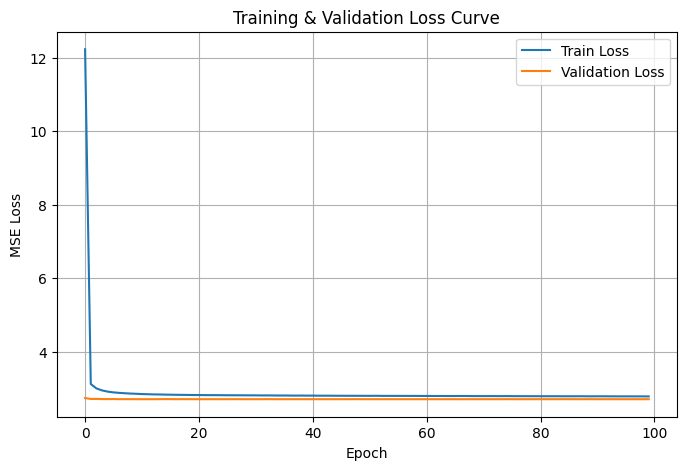

In [54]:
trained_model = training_model(100,0.2)

In [56]:
model_1, duple = trained_model

In [67]:
def test_data(conc):
    input_transmissions = []
    out_dir = os.path.expanduser('~/Downloads/transmissions/size_10')
    for config in range(5000,5050):
        file = os.path.join(out_dir ,  f'lead_size_{size}_conc_{int(conc)}_config_{config}.csv')
        trans = np.loadtxt(file,  delimiter=',', skiprows=1)[:,1]
        
        input_transmissions.append(np.clip(trans[:200],0,pris[:200]))


    return input_transmissions


conc_7 = test_data(7)

In [71]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [75]:
model_1.eval()

predictions = []
targets = []
device = "cpu"


with torch.no_grad():
    for step, (xb, yb) in enumerate(test_loader):
        print(step)
        xb, yb = xb.to(device), yb.to(device)
        pred = model_1(xb)
        predictions.append(pred.cpu())
        targets.append(yb.cpu())


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [95]:
pred_1 = model_1(test_dataset[1][0].unsqueeze(0)).detach().cpu().numpy()

In [96]:
pred_1[0]

array([3.3921692, 7.0644746, 7.026357 , 6.978733 , 6.9104195, 6.8089886,
       6.6399293, 6.3209834, 4.852948 , 4.4366527, 4.4783406, 4.5380297,
       4.6028533, 4.6273904, 4.6941605, 4.7266464, 4.773645 , 4.8118477,
       4.897308 , 4.9468684, 5.034899 , 5.1065063, 5.15956  , 5.255054 ,
       5.2452607, 5.254361 , 5.3059816, 5.306476 , 5.295176 , 5.2554955,
       5.226063 , 4.9881268, 5.1180215, 5.044671 , 5.0708814, 5.032077 ,
       5.032145 , 5.032259 , 5.059596 , 5.1100845, 5.157838 , 5.145793 ,
       5.1584415, 5.277358 , 5.340211 , 5.424361 , 5.424273 , 5.5223217,
       5.548873 , 5.5526056, 5.6141334, 5.6972914, 5.71201  , 5.743106 ,
       5.8232565, 5.819621 , 5.8432484, 5.875466 , 5.9410257, 6.010547 ,
       6.0463285, 6.0374346, 6.0703936, 6.0472555, 6.0611215, 6.0254946,
       5.9360995, 5.795735 , 5.451762 , 4.5899115, 4.682285 , 4.74958  ,
       4.7414107, 4.746673 , 4.805916 , 4.832978 , 4.8518896, 4.877972 ,
       4.919888 , 4.942655 , 4.9683437, 5.011512 , 

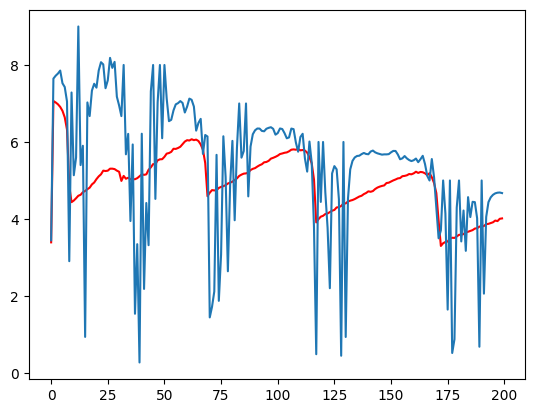

In [98]:
plt.plot(pred_1[0],color= 'red')
plt.plot(test_dataset[1][1])